HRP (Hierarchical Risk Parity) portfolio optimization method is based on the correlation among financial assets. This method was proposed by Marco Lopez de Prado ("Building a Diversified Portfolio that Outperforms the Sample" (2016)) with an attempt to overcome the limitations of traditional methods such as Minimum Variance Portfolio or Optimal Risk Portfolio.



The HRP works in four main steps :

1. Cluster the given assets hierarchically based on their correlation, which provides an understanding of how closely related the assets are.

2. Create a tree structure based on the clustering results. Each node in the tree represents an asset or group of assets, with the parent node representing the correlation of the child nodes.

3. Balance the variance by equally distributing risk at each node. This process aims to distribute risk evenly at each level of the tree.

4. the portfolio is restructured so that the risk of the entire portfolio is evenly distributed among each asset.

By considering the correlation among assets, HRP optimally distributes portfolio risk, which helps maintain stable performance even in highly volatile market conditions. Therefore, HRP was designed for investors who want to achieve stable returns in any risky financial situation.


If you want obtain more details of HRP portfolio, visit this website :
 https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/

First, we install the required packages. "ClusterPortfolios" package is not installed based on CRAN, so this package should be installed via devtools or remote package.

In [ ]:
devtools::install_github("https://github.com/jpfitzinger/ClusterPortfolios")

And then, install other pakcages

In [ ]:
install.packages('pacman')

In [9]:
pacman::p_load(dplyr, tidyquant, plotly, ClusterPortfolios,
               tidyverse , purrr)

options(scipen = 999)
'%+%' = paste0

Create a portfolio using a set of representative US ETFs. I collected this ETFs tickers and defined as "tickers"

In [5]:
tickers = c("SPY", "IVV", "VOO", "VTI", "QQQ", "VEA", "VUG", "VTV", "IEFA", "BND", "AGG", "IWF", "IJH", "VIG", "IJR", "IEMG", "VWO", "VGT", "VXUS", "XLK", "IWM", "VO", "GLD", "IWD", "VB", "SCHD", "BNDX", "ITOT", "VYM", "EFA", "RSP", "TLT", "VCIT", "XLV", "SCHX", "IVW", "QUAL", "VEU", "XLF", "MUB", "VCSH")

We have established a timeframe for data collection, the timeframe will be from January 1st, 2016 to January 1st, 2024.

In [6]:
start = "2016-01-01" ; end = "2024-01-01"

We downloaded the necessary data and performed preprocessing on it. In order to obtain the log return of each ETF, we utilized the '**tq_transmute**' function to convert the existing data into log return data. Plus, I used **'pivot_wider**' function to facilitate to manage data

In [7]:
data = tq_get(
  tickers,
  from = start,
  to = end
) %>%
  group_by(symbol) %>%
  tq_transmute(select = adjusted,
               mutate_fun = periodReturn,
               period = "monthly",
               type = "log") %>%
  rename(logret = monthly.returns) %>%
  pivot_wider(
    names_from = symbol,
    values_from = logret
  ) %>%
  drop_na()

In [8]:
head(data)

date,SPY,IVV,VOO,VTI,QQQ,VEA,VUG,VTV,IEFA,⋯,TLT,VCIT,XLV,SCHX,IVW,QUAL,VEU,XLF,MUB,VCSH
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-29,-0.0369907635,-0.0372187066,-0.036240980,-0.0438722110,-0.05028437,-0.04177825,-0.044686346,-0.036547285,-0.043875059,⋯,0.0470434506,0.0033192899,-0.062119121,-0.040299724,-0.035251847,-0.032428288,-0.040411875,-0.07321945,0.0098183597,0.0026568239
2016-02-29,-0.0008265676,-0.0005653704,-0.002083711,-0.0001016589,-0.01577746,-0.03133052,-0.004008170,0.001029978,-0.032101223,⋯,0.0303934881,0.0107279366,-0.003617162,-0.001524071,-0.007403492,0.005989369,-0.024704387,-0.02943444,0.0002157515,0.0022870477
2016-03-31,0.0651006909,0.0605429629,0.066474015,0.0686851744,0.06627994,0.06944211,0.069552950,0.064838810,0.067730304,⋯,-0.0009334233,0.0230633655,0.026714647,0.062302403,0.065025046,0.057391487,0.079761972,0.06914468,0.0044073228,0.0118785638
2016-04-29,0.0039333164,0.0039119551,0.003494568,0.0065609976,-0.03238658,0.02286908,-0.007922224,0.015057924,0.019750978,⋯,-0.0073932211,0.0097900156,0.029223631,0.004290731,-0.011892313,-0.003969916,0.020869769,0.03536735,0.0066345541,0.0037479161
2016-05-31,0.0168685515,0.0167773861,0.017393692,0.0171957035,0.04277250,-0.00300086,0.024597895,0.010584580,0.001290834,⋯,0.0080225102,0.0005038175,0.022106865,0.017381316,0.025178330,0.010652644,-0.007975340,0.01870023,0.0027637564,-0.0006625759
2016-06-30,0.0034694004,0.0025325860,0.003217527,0.0027306268,-0.02304366,-0.02081229,-0.006635700,0.011190925,-0.026330946,⋯,0.0670435309,0.0257973098,0.009049837,0.002083345,-0.003111717,0.004828499,-0.007351897,-0.03286101,0.0159717746,0.0122469256


HRP function from "Clusteringportfolio" package requires covariance of each asset, so we need to calculate this covariance value.

For "buy and hold" strategy, I calculated covariance using "window expanded" method

It is necessary to calculate the covariance value for each asset in Clusteringportfolio's HRP function. For the "buy and hold" strategy, the covariance was calculated using the "window expanded" method. Thus,I used "map" function to use window expanded covariance calculation method.

Of course, you can use "for loop" instead of "map" from purrr, but "for loop" is too slow to calculate numerious operations.

In [10]:
weight_data = map(2:nrow(data), ~{
  data %>%
    slice(1:.x) %>%
    select(-date) %>%
    cov(.) %>%
    HRP %>%
    as.data.frame() %>%
    `colnames<-`(
      data %>%
        slice(1:.x) %>%
        pull(date) %>%
        last() %>% as.character()
    ) %>%
    rownames_to_column(var = "symbol")
}) %>%
  reduce(left_join, by = "symbol") %>%
  mutate_at(vars(-symbol),~round(.,digits = 5))

In [11]:
head(weight_data)

,symbol,2016-02-29,2016-03-31,2016-04-29,2016-05-31,2016-06-30,2016-07-29,2016-08-31,2016-09-30,2016-10-31,⋯,2023-03-31,2023-04-28,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-29,2023-10-31,2023-11-30,2023-12-29
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SPY,0.00000,0.00007,0.00026,0.00050,0.00192,0.00180,0.00239,0.00289,0.00421,⋯,0.00562,0.00562,0.00564,0.00555,0.00554,0.00553,0.00560,0.00560,0.00601,0.00625
2,IVV,0.00003,0.00009,0.00027,0.00053,0.00204,0.00187,0.00249,0.00298,0.00437,⋯,0.00559,0.00559,0.00562,0.00552,0.00551,0.00550,0.00557,0.00557,0.00598,0.00622
3,VOO,0.00001,0.00011,0.00025,0.00049,0.00188,0.00176,0.00233,0.00283,0.00411,⋯,0.00561,0.00561,0.00564,0.00555,0.00553,0.00552,0.00559,0.00559,0.00601,0.00625
4,VTI,0.00000,0.00002,0.00010,0.00020,0.00078,0.00073,0.00097,0.00117,0.00170,⋯,0.00263,0.00263,0.00264,0.00260,0.00259,0.00259,0.00262,0.00262,0.00281,0.00291
5,QQQ,0.00001,0.00005,0.00027,0.00062,0.00129,0.00093,0.00111,0.00156,0.00245,⋯,0.00306,0.00307,0.00309,0.00306,0.00306,0.00306,0.00308,0.00307,0.00324,0.00335
6,VEA,0.00005,0.00005,0.00040,0.00075,0.00066,0.00059,0.00084,0.00105,0.00145,⋯,0.00350,0.00350,0.00347,0.00345,0.00344,0.00341,0.00348,0.00348,0.00371,0.00385


Slice_data corresponds to weight_data. I fit this dataframe with weight_data and compute portfolio return named "pf_ret".

"pf_ret" is calculated as the sum of "weight(Asset) x return(Asset)", where those weights from weight_data have already been calculated through HRP function.

In [12]:
slice_data = data %>%
  slice(-1)

slice_data = slice_data %>%
  mutate(
    pf_ret = rowSums(select(slice_data,-date) * t(select(weight_data,-symbol))),
    cum_ret = cumprod(1+pf_ret)-1
  )


mdata consists of market data and returns. I created this dataframe to compare return performance with the HRP portfolio. Therefore, this dataframe is composed of data and cumulative returns. (monthly rebalancing)

In [ ]:
mdata = tq_get(
  "^GSPC",
  from = start,
  to = end
) %>%
  group_by(symbol) %>%
  tq_transmute(select = adjusted,
               mutate_fun = periodReturn,
               period = "monthly",
               type = "log") %>%
  rename(logret = monthly.returns) %>%
  drop_na() %>%
  filter(date >= first(select(slice_data,date)) & date <=last(select(slice_data,date))) %>%
  mutate(
    cum_ret = cumprod(1+logret)-1
  )

Visualization !

In [ ]:
p1 = slice_data %>%
  plot_ly() %>%
  add_lines(
    x=~date,
    y=~cum_ret,
    name = "cumulative return"
  ) %>%
  add_lines(
    data = mdata,
    x=~date,
    y=~cum_ret,
    name = "Market return"
  )

p2 = slice_data %>%
  plot_ly() %>%
  add_bars(
    x=~date,
    y=~pf_ret,
    name = "portfolio return"
  )

p3 = weight_data %>%
  pivot_longer(
    cols = -symbol,
    names_to = "date",
    values_to = "weight"
  ) %>%
  plot_ly(
    x=~date,
    y=~weight,
    color = ~symbol,
    type = "bar"
  ) %>%
  layout(
    barmode = "stack"
  )


subplot(p1,p2,p3,nrows = 3,heights = c(.5,.2,.3),shareX = TRUE) %>%
  layout(
    title = "<br>" %+% "HRP portfolio" %+% "</br>"
  )


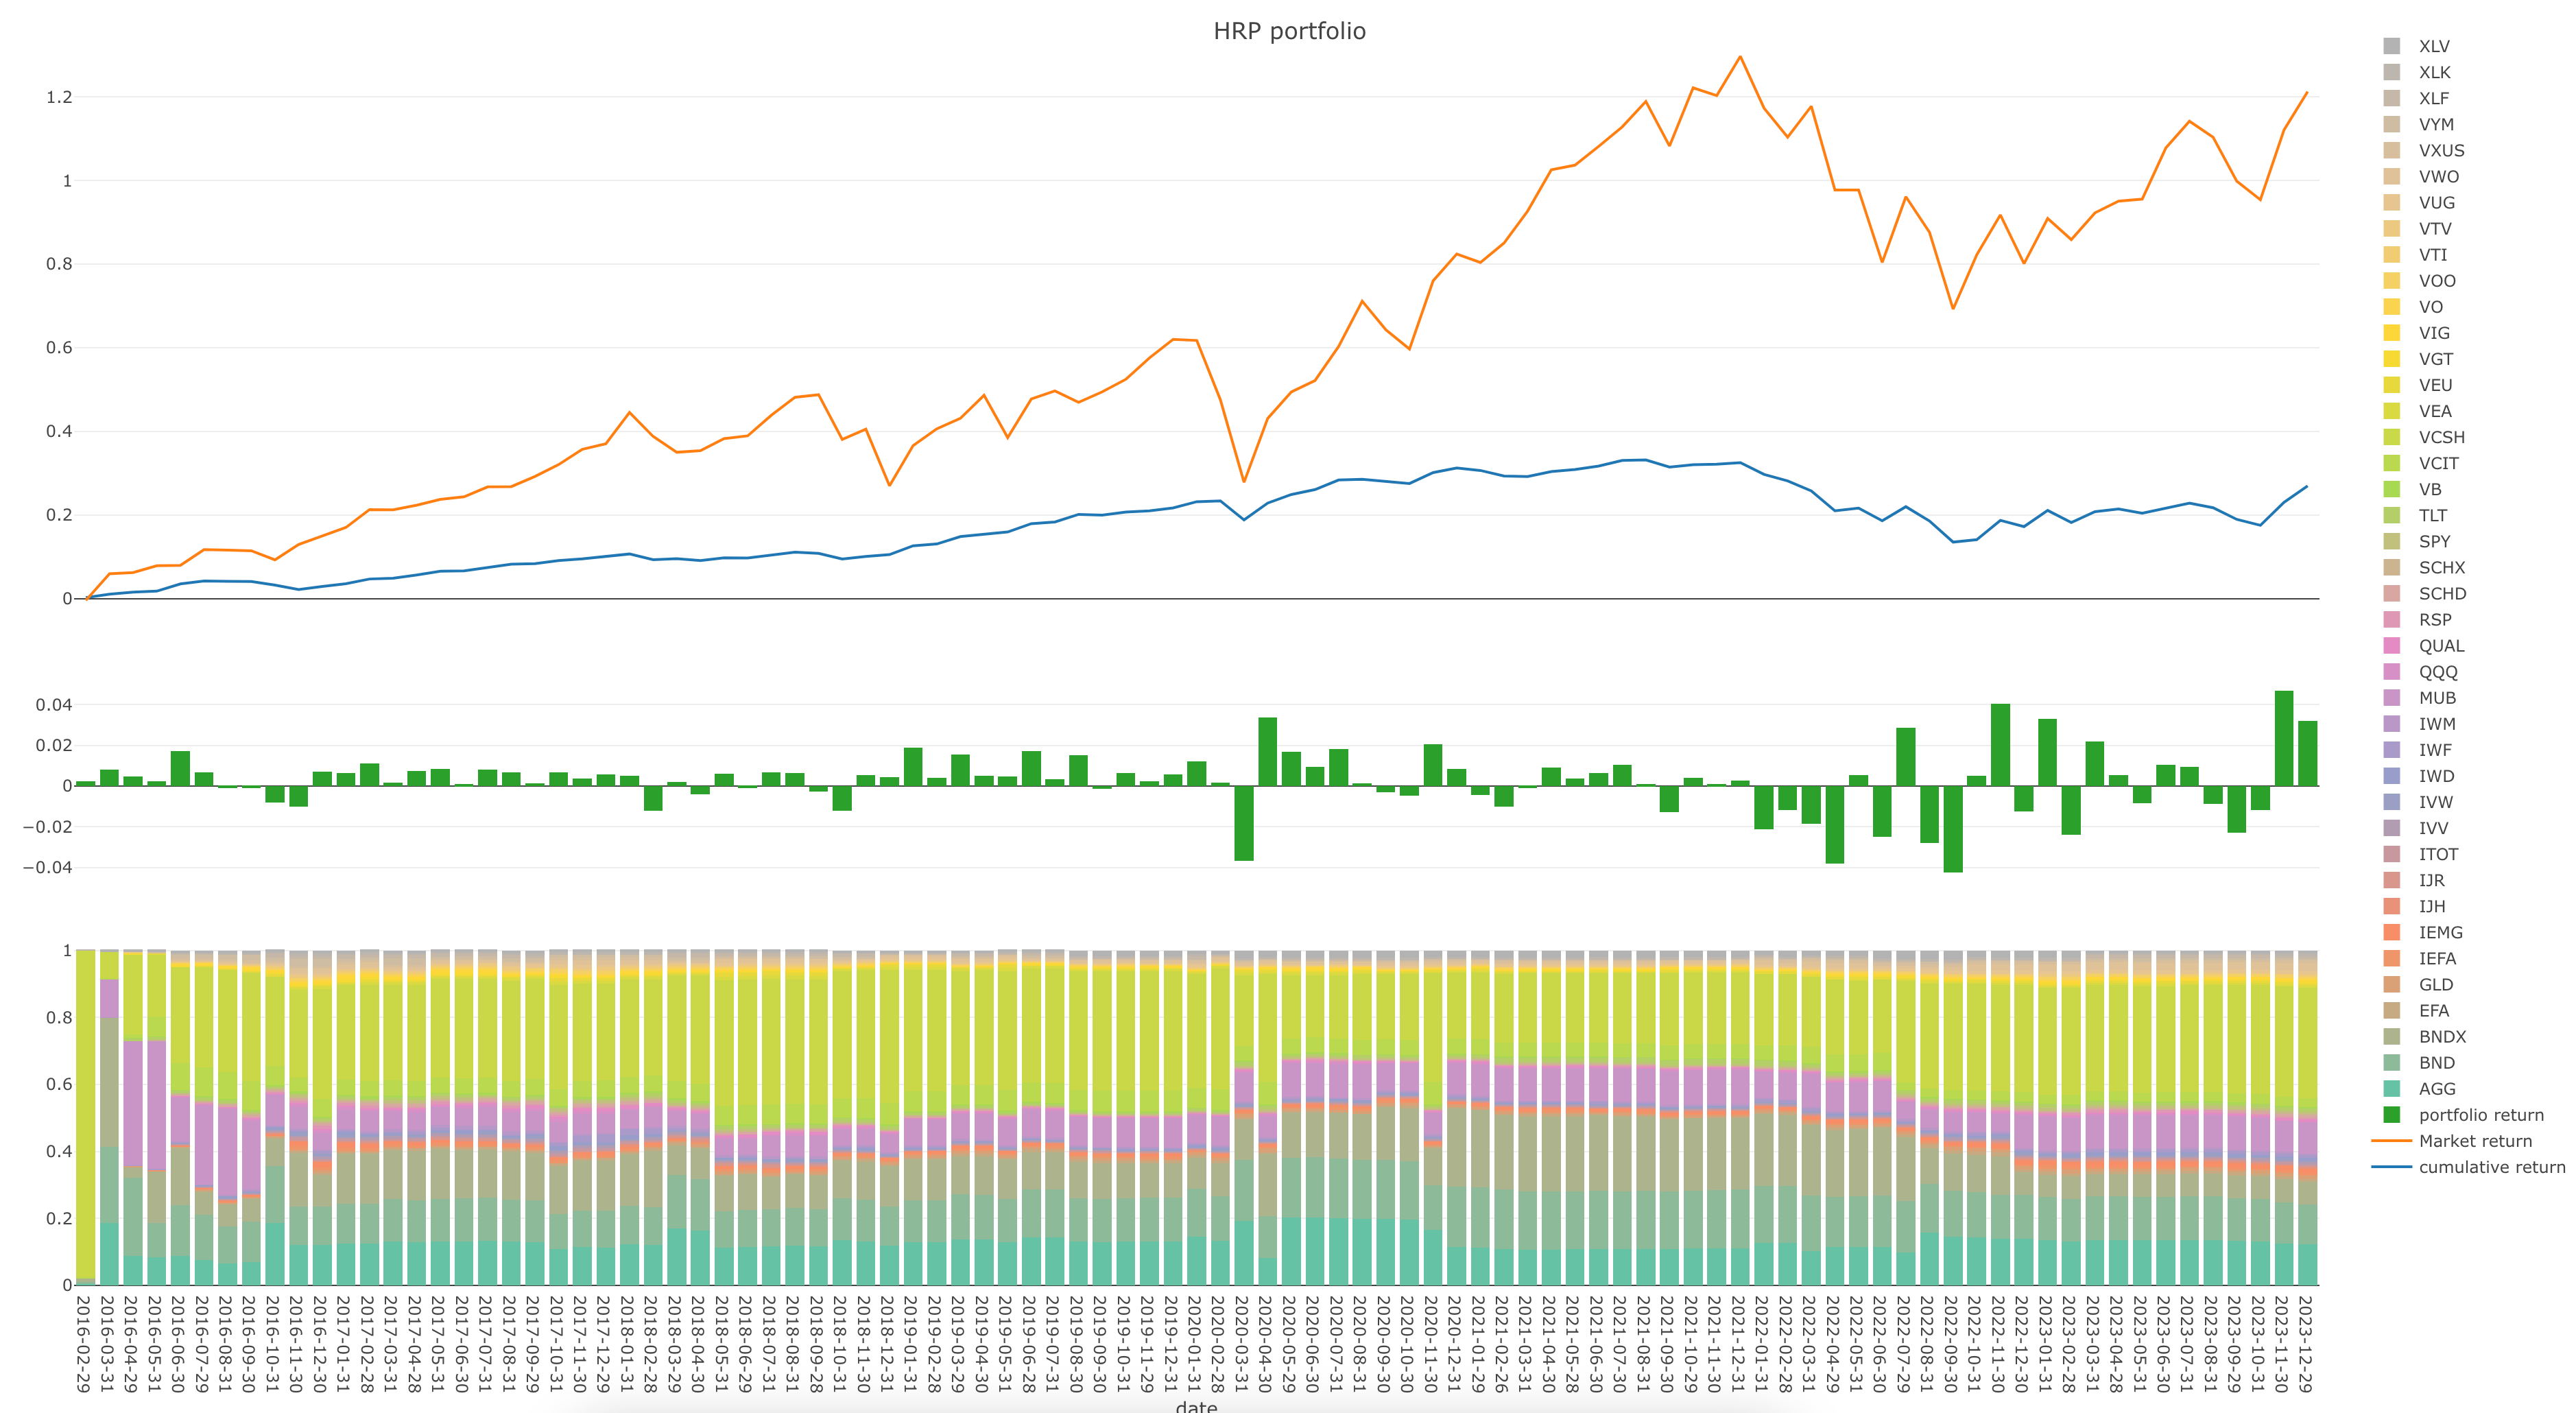

1. Blue line is the cumulative return of HRP portfolio, Orange line is the cumulative return of the market
2. Green bar plot is the return of HRP portfolio each month
3. the stacked bar plot shows the chage in weights of each asset of the HRP portfolio


It can be observed that the performance of the HRP portfolio does not exceed the cumulative return of the market. This is because the HRP portfolio is not designed to outperform the market return. It is important to remember that the primary objective of the HRP portfolio is to achieve stable returns by distributing risks via clustering trees. As a result, the cumulative return of HRP is more stable than that of the market.